### Начальные данные

In [1]:
import pandas as pd

data = pd.Series(data={
    'a':0.0,
    'b':2.0,
    'k':2.0,
    'T':0.1,
    'h':0.1
})

data

a    0.0
b    2.0
k    2.0
T    0.1
h    0.1
dtype: float64

In [2]:
def u0(x): return 0
def m1(t): return 0
def m2(t): return 2*t
def f(x, t): return 1
def tau(h) : return 0.45 * h ** 2 / data['k']

### Явная схема Лаосонена

In [3]:
import numpy as np


def _laosonen(y_current: list, tn_current: float, h: float) -> list:
    arr = [y_current[n] + tau(h) * (data['k'] *
                                    (y_current[n+1] - 2 *
                                     y_current[n] + y_current[n - 1])
                                    / h ** 2 + f(data['a'] + h * n, tn_current))
           for n in np.arange(1, len(y_current)-1)]
    arr = np.append(m1(tn_current + tau(h)), arr)
    return np.append(arr, m2(tn_current + tau(h)))


def laosen(h: float) -> pd.DataFrame:

    l1 = [u0(i) for i in np.arange(data['a'] + h, data['b'],
                                             step=h)]

    l1 = np.append(m1(0), l1)
    l1 = np.append(l1, m2(0))
    
    result = np.array(l1)

    tns = np.arange(0, data['T'] + tau(h), tau(h))

    for tn in tns:
        l1 = _laosonen(l1, tn_current=tn, h=h)
        result = np.append(result, l1)

    result = pd.DataFrame(data=result.reshape(tns.shape[0]+1, -1), columns=np.arange(
        data['a'], data['b'] + h, h), index=np.append(0,tns))
    result.index.name = 't_n'
    result.columns.name = 'x_i'
    return result

### Отображение полученных слоев

In [4]:
import matplotlib.pyplot as plt

def print_contour(df: pd.DataFrame) -> None:
    plt.style.use('_mpl-gallery-nogrid')
    fig, ax = plt.subplots()
    X, Y = np.meshgrid(df.columns, df.index)
    Z = df.values

    contour = ax.contourf(X, Y, Z)
    cbar = fig.colorbar(contour)
    fig.set_figheight(4)
    fig.set_figwidth(6)
    ax.set_xlabel('x_i')
    ax.set_ylabel('t_n')
    fig.tight_layout()
    


### Неявная схема "Зонтик"

In [5]:
def TDMA(a,b,c,d):
    n = len(d)
    w= np.zeros(n-1,float)
    g= np.zeros(n, float)
    p = np.zeros(n,float)
    
    
    w[0] = c[0]/b[0]
    g[0] = d[0]/b[0]

    for i in range(1,n-1):
        w[i] = c[i]/(b[i] - a[i-1]*w[i-1])
    for i in range(1,n):
        g[i] = (d[i] - a[i-1]*g[i-1])/(b[i] - a[i-1]*w[i-1])
    p[n-1] = g[n-1]
    for i in range(n-1,0,-1):
        p[i-1] = g[i-1] - w[i-1]*p[i]
    return p

In [6]:
def _umbrella(y_current: list, tn_current: float, h: float) -> list:
    gamma = data['k'] * tau(h) / h ** 2
    d = -1 * np.array([y_current[i] + tau(h) * f(data['a'] + h * i, tn_current)
                       for i in np.arange(len(y_current))])
    
    a = np.repeat(gamma, len(d) - 1)
    b = np.repeat(-(1 + 2 * gamma), len(d))
    b[0] = -(1 + gamma)
    b[-1] = -(1 + gamma)
    c = np.repeat(gamma, len(d) - 1)

    result = TDMA(a, b, c, d)
    result[0] = m1(tn_current)
    result[-1] = m2(tn_current)
    return result


def umbrella(h: float) -> pd.DataFrame:

    l1 = [u0(i) for i in np.arange(data['a'] + h, data['b'],
                                             step=h)]
    
    l1 = np.append(m1(0), l1)
    l1 = np.append(l1, m2(0))
    
    result = np.array(l1)

    tns = np.arange(0, data['T'] + tau(h), tau(h))

    for tn in tns:
        l1 = _umbrella(l1, tn_current=tn, h=h)
        result = np.append(result, l1)

    result = pd.DataFrame(data=result.reshape(tns.shape[0]+1, -1), columns=np.arange(
        data['a'], data['b'] + h, h), index=np.append(0, tns))
    result.index.name = 't_n'
    result.columns.name = 'x_i'
    return result


### Неявная схема Кранка-Николсона

In [7]:
def _krank_nikols(y_current: list, tn_current: float, h: float) -> list:
    gamma = 0.5 * data['k'] * tau(h) / h ** 2
    d = -1 * np.array([y_current[i] + gamma * \
                        (y_current[i+1] - 2*y_current[i] + y_current[i-1]) + \
                        tau(h) * f(data['a'] + h * i, tn_current + 0.5 * tau(h))
                        for i in np.arange(1, len(y_current) -1)])
    
    a = np.repeat(gamma, len(d) - 1)
    b = np.repeat(-(1 + 2 * gamma), len(d))
    b[0] = -(1 + gamma)
    b[-1] = -(1 + gamma)
    c = np.repeat(gamma, len(d)-1)

    result = TDMA(a, b, c, d)
    result = np.append(m1(tn_current+tau(h)), result)
    result = np.append(result, m2(tn_current+tau(h)))

    return result


def krank_nikols(h: float) -> pd.DataFrame:

    l1 = [u0(i) for i in np.arange(data['a'] + h, data['b'],
                                             step=h)]
    
    l1 = np.append(m1(0), l1)
    l1 = np.append(l1, m2(0))
    
    result = np.array(l1)

    tns = np.arange(0, data['T'] + tau(h), tau(h))

    for tn in tns:
        l1 = _krank_nikols(l1, tn_current=tn, h=h)
        result = np.append(result, l1)

    result = pd.DataFrame(data=result.reshape(tns.shape[0]+1, -1), columns=np.arange(
        data['a'], data['b'] + h, h), index=np.append(0, tns))
    result.index.name = 't_n'
    result.columns.name = 'x_i'
    return result

In [18]:
from typing import Callable


def get_inaccuracy(y_current: float, y_prev: float): return np.abs(
    (y_prev - y_current) / y_current)


def condition(inaccuracy: float, p: int): return inaccuracy <= 10e-4 * \
    (np.power(2, p+1) - 2) / 2


def find_h(method: Callable[[float], pd.DataFrame], p: int) -> tuple:
    h = data['h']
    inaccuracies = []
    res = method(h)

    mid_value = res.iloc[-1].median()

    while(True):
        h /= 2
        res = method(h)
        new_mid_value = res.iloc[-1].median()

        inaccuracy = get_inaccuracy(new_mid_value, mid_value)
        inaccuracies += [inaccuracy]

        if(condition(inaccuracy, p)):
            mid_value = new_mid_value
            break

        mid_value = new_mid_value

    return (h, inaccuracies, res)


In [19]:
h, inaccuracies,res = find_h(krank_nikols, 2)

In [20]:
inaccuracies

[0.027932960893867223, 0.004207573632554634, 0.002108222066154369]

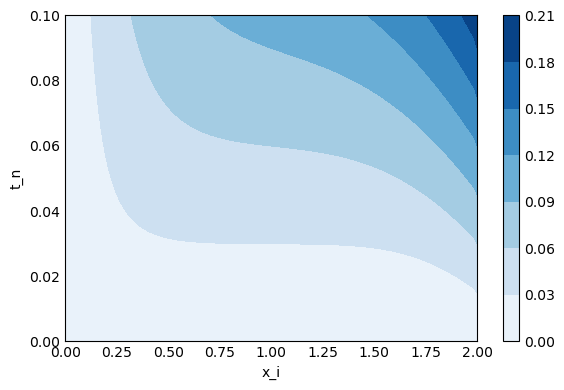

In [10]:
print_contour(res)